# Seq2Seq Time-Series Forecasting using: _LSTM, LSTM Encoder-Decoder, CNN-LSTM Encoder-Decoder & ConvLSTM Encoder-Decoder_ architectures with TF2.

The _Household Power Consumption_  dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts).
- voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering_1: Active energy for kitchen (watt-hours of active energy).
- sub_metering_2: Active energy for laundry (watt-hours of active energy).
- sub_metering_3: Active energy for climate control systems (watt-hours of active energy).


- [Multivariate, Multistep Time Series Forecasting in TF & Keras](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)
- [Using TimeDistributed Layer in Keras](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)
- [Reference](https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/)
- [Dataset reference](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, Bidirectional, GRU, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.layers import Conv1D, ConvLSTM2D, MaxPooling1D
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-05-28 11:47:09.163846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:47:09.201698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:47:09.201955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 11:47:09.202728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
# path_to_file = "D:/Deep_Learning_resources/Sequence_Modelling_resources/Datasets/Household_Power_Consumption-files/"

In [5]:
# Read in dataset-
# data = pd.read_csv(path_to_file + "household_power_consumption_cleaned.csv", low_memory = False)
data = pd.read_csv("Datasets/household_power_consumption_cleaned.csv", low_memory = False)

In [6]:
# Data shape/dimension-
data.shape

(2075259, 9)

In [7]:
data.dtypes

datetime                  object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
sub_metering_4           float64
dtype: object

In [8]:
# Convert 'date_time' attribute to datetime, sort & reset indices-
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by = 'datetime', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [9]:
# Sanity check-
data.dtypes

datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
sub_metering_4                  float64
dtype: object

In [10]:
# Sanity check-
data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [11]:
print(f"min date time: {data['datetime'].min()} & max: {data['datetime'].max()}")

min date time: 2006-12-16 17:24:00 & max: 2010-11-26 21:02:00


In [12]:
# Check for missing values-
data.isna().values.any()

False

In [13]:
data.isna().sum().sum()

0

In [14]:
# Scale dataset-
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(data.iloc[:, 1:])

In [15]:
print(f"Post-scaling min and max sanity check:\n")
for col in range(data_scaled.shape[1]):
    print(f"{col}; min = {data_scaled[:, col].min():.4f} & max: {data_scaled[:, col].max():.4f}")

Post-scaling min and max sanity check:

0; min = -0.9609 & max: 9.5125
1; min = -1.0985 & max: 11.2468
2; min = -5.4433 & max: 4.1091
3; min = -0.9967 & max: 9.8759
4; min = -0.1821 & max: 14.1467
5; min = -0.2227 & max: 13.5777
6; min = -0.7646 & max: 2.9111
7; min = -1.2236 & max: 12.0836


#### Split dataset in training and testing sets: _90:10_ split

In [16]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(data_scaled[: int(len(data_scaled) * 0.9)]), len(data_scaled[int(len(data_scaled) * 0.9): ])

(1867733, 207526)

In [17]:
# Sanity check-
len(data_scaled[: int(len(data_scaled) * 0.9)]) + len(data_scaled[int(len(data_scaled) * 0.9): ]) == len(data_scaled)

True

In [18]:
train_data = data_scaled[: int(len(data_scaled) * 0.9), :]
test_data = data_scaled[int(len(data_scaled) * 0.9):, :]

In [19]:
# Sanity check-
train_data.shape, test_data.shape

((1867733, 8), (207526, 8))

In [20]:
# Further sanity check-
train_data[-5:, :]

array([[-0.77504014, -0.12156273,  0.61220427, -0.77109748, -0.18211869,
        -0.22272701, -0.76463778, -0.4984051 ],
       [-0.77693646, -0.13932578,  0.37764   , -0.77109748, -0.18211869,
        -0.22272701, -0.6460642 , -0.60647994],
       [-0.77693646, -0.12156273,  0.63689524, -0.77109748, -0.18211869,
        -0.22272701, -0.6460642 , -0.60647994],
       [-0.77693646, -0.12156273,  0.62146338, -0.77109748, -0.18211869,
        -0.22272701, -0.76463778, -0.50189139],
       [-0.77504014, -0.10379968,  0.81281844, -0.77109748, -0.18211869,
        -0.22272701, -0.6460642 , -0.60299366]])

In [21]:
test_data[:5, :]

array([[-0.71435811,  0.482381  ,  0.70170905, -0.68086846, -0.18211869,
        -0.22272701, -0.6460642 , -0.49143253],
       [-0.70487654,  0.80211592,  0.58134055, -0.68086846, -0.18211869,
        -0.22272701, -0.76463778, -0.36941251],
       [-0.70487654,  0.81987897,  0.70479542, -0.68086846, -0.18211869,
        -0.22272701, -0.6460642 , -0.47400107],
       [-0.70298023,  0.85540507,  0.88997774, -0.68086846, -0.18211869,
        -0.22272701, -0.6460642 , -0.47051482],
       [-0.70487654,  0.85540507,  0.99182802, -0.68086846, -0.18211869,
        -0.22272701, -0.76463778, -0.36941251]])

In [22]:
data_scaled[1867728:1867738, :]

array([[-0.77504014, -0.12156273,  0.61220427, -0.77109748, -0.18211869,
        -0.22272701, -0.76463778, -0.4984051 ],
       [-0.77693646, -0.13932578,  0.37764   , -0.77109748, -0.18211869,
        -0.22272701, -0.6460642 , -0.60647994],
       [-0.77693646, -0.12156273,  0.63689524, -0.77109748, -0.18211869,
        -0.22272701, -0.6460642 , -0.60647994],
       [-0.77693646, -0.12156273,  0.62146338, -0.77109748, -0.18211869,
        -0.22272701, -0.76463778, -0.50189139],
       [-0.77504014, -0.10379968,  0.81281844, -0.77109748, -0.18211869,
        -0.22272701, -0.6460642 , -0.60299366],
       [-0.71435811,  0.482381  ,  0.70170905, -0.68086846, -0.18211869,
        -0.22272701, -0.6460642 , -0.49143253],
       [-0.70487654,  0.80211592,  0.58134055, -0.68086846, -0.18211869,
        -0.22272701, -0.76463778, -0.36941251],
       [-0.70487654,  0.81987897,  0.70479542, -0.68086846, -0.18211869,
        -0.22272701, -0.6460642 , -0.47400107],
       [-0.70298023,  0.85540507

In [23]:
def split_series_multivariate(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s) for multivariate, multistep and multivariate
    output time-series modeling.
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        # past, future = data[window_start: past_end, :], data[past_end: future_end, 4]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)


In [24]:
def split_series_univariate(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s) for multivariate, multistep output
    time-series modeling.
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        # past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        past, future = data[window_start: past_end, :], data[past_end: future_end, 0]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)


In [28]:
# Define hyper-parameters for Seq2Seq modeling-
n_past = 30
n_future = 10
n_features = 8

In [26]:
# Split into training and testing sets for supervised task-
X_train, y_train = split_series_univariate(train_data, n_past, n_future)
X_test, y_test = split_series_univariate(test_data, n_past, n_future)

In [27]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1867697, 30, 8), y_train.shape: (1867697, 7)
X_test.shape: (207490, 30, 8), y_test.shape: (207490, 7)


In [68]:
# X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)).shape, y_train.reshape((y_train.shape[0], y_train.shape[1], n_features)).shape

In [69]:
# X_test.reshape((X_test.shape[0], X_test.shape[1], n_features)).shape, y_test.reshape((y_test.shape[0], y_test.shape[1], n_features)).shape

In [29]:
# Specify hyper-parameters-
num_epochs = 100
batch_size = 256

### Multivariate, Multistep Time Series Forecasting with _Seq2Seq_ architecture

LSTMs offer a number of benefits when it comes to multi-step time series forecasting; they are:

- Native Support for Sequences. LSTMs are a type of recurrent network, and as such are designed to take sequence data as input, unlike other models where lag observations must be presented as input features.

- Multivariate Inputs. LSTMs directly support multiple parallel input sequences for multivariate inputs, unlike other models where multivariate inputs are presented in a flat structure.

- Vector Output. Like other neural networks, LSTMs are able to map input data directly to an output vector that may represent multiple output time steps.

Further, specialized architectures have been developed that are specifically designed to make multi-step sequence predictions, generally referred to as sequence-to-sequence prediction, or seq2seq for short. This is useful as multi-step time series forecasting is a type of seq2seq prediction.

An example of a recurrent neural network architecture designed for seq2seq problems is the encoder-decoder LSTM.

An encoder-decoder LSTM is a model comprised of two sub-models:
- one called the encoder that reads the input sequences and compresses it to a fixed-length internal representation, (and)
- an output model called the decoder that interprets the internal representation and uses it to predict the output sequence.

The encoder-decoder approach to sequence prediction has proven much more effective than outputting a vector directly and is the preferred approach.

Generally, LSTMs have been found to not be very effective at auto-regression type problems. These are problems where forecasting the next time step is a function of recent time steps.

In [29]:
def lstm_model(n_future):
    '''
    Multivariate, multistep time-series forecasting
    with LSTM RNN architecture.
    
    n_future: multi-step future forecasting
    '''
    model = Sequential()

    model.add(
        LSTM(
            units = 200, activation = tf.keras.activations.tanh,
            return_state = False, input_shape = (n_past, n_features)
        )
    )

    model.add(
        Dense(units = 100, activation = tf.keras.activations.relu)
    )

    model.add(
        Dense(units = n_future, activation = None)
    )
    
    # Compile model-
    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    )
    
    return model


In [62]:
def lstm_stacked_model(n_future):
    '''
    Multivariate, multistep time-series forecasting
    with Stacked LSTM RNN architecture.
    
    n_future: multi-step future forecasting
    '''
    model = Sequential()

    model.add(
        LSTM(
            units = 200, activation = tf.keras.activations.tanh,
            input_shape = (n_past, n_features),
            return_sequences = True
        )
    )
    
    model.add(
        LSTM(
            units = 100, activation = tf.keras.activations.tanh,
            return_sequences = False
        )
    )

    model.add(
        Dense(units = 100, activation = tf.keras.activations.relu)
    )

    model.add(
        Dense(units = n_future, activation = None)
    )
    
    # Compile model-
    model.compile(
        loss = tf.keras.losses.Huber(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    )
    
    return model


In [31]:
# Initialize an instance-
model_lstm = lstm_model(n_future = n_future)

2022-05-26 10:05:19.074169: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-26 10:05:19.075652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 10:05:19.075990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 10:05:19.076257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [63]:
# Initialize an instance of Stacked LSTM architecture-
model_lstm_stacked = lstm_stacked_model(n_future = n_future)

In [33]:
# Get model summary-
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               167200    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 7)                 707       
                                                                 
Total params: 188,007
Trainable params: 188,007
Non-trainable params: 0
_________________________________________________________________


In [64]:
model_lstm_stacked.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 200)           167200    
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 7)                 707       
                                                                 
Total params: 298,407
Trainable params: 298,407
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Sanity check-
y_pred = model_lstm(X_train[:batch_size, :])

2022-05-26 10:05:39.843938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-26 10:05:39.900206: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [35]:
# Sanity check-
y_pred.shape, y_train[:batch_size, :].shape

(TensorShape([256, 7]), (256, 7))

In [36]:
del y_pred

In [65]:
y_pred_bi = model_lstm_stacked(X_train[:batch_size, :])

In [68]:
y_pred_bi.shape, y_train[:batch_size, :].shape

(TensorShape([256, 7]), (256, 7))

In [27]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 10e-4,
    patience = 5, verbose = 1,
    mode = 'auto', baseline = None,
    restore_best_weights = True
)

In [39]:
# Train model-
history_model = model_lstm.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping_criterion]
)

Epoch 1/100
7296/7296 [==============================] - 26s 3ms/step - loss: 0.1605 - val_loss: 0.1027
Epoch 2/100
7296/7296 [==============================] - 22s 3ms/step - loss: 0.1418 - val_loss: 0.0985
Epoch 3/100
7296/7296 [==============================] - 22s 3ms/step - loss: 0.1361 - val_loss: 0.0985
Epoch 4/100
7296/7296 [==============================] - 22s 3ms/step - loss: 0.1319 - val_loss: 0.0979
Epoch 5/100
7296/7296 [==============================] - 22s 3ms/step - loss: 0.1282 - val_loss: 0.0976
Epoch 6/100
7296/7296 [==============================] - 23s 3ms/step - loss: 0.1248 - val_loss: 0.0982
Epoch 7/100
7296/7296 [==============================] - 24s 3ms/step - loss: 0.1215 - val_loss: 0.0998
Epoch 7: early stopping


In [69]:
# Train Stacked LSTM model-
history_model_stacked_lstm = model_lstm_stacked.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test),
    callbacks = [early_stopping_criterion]
)

Epoch 1/100
7296/7296 [==============================] - 40s 5ms/step - loss: 0.0661 - val_loss: 0.0471
Epoch 2/100
7296/7296 [==============================] - 38s 5ms/step - loss: 0.0582 - val_loss: 0.0435
Epoch 3/100
7296/7296 [==============================] - 39s 5ms/step - loss: 0.0555 - val_loss: 0.0422
Epoch 4/100
7296/7296 [==============================] - 38s 5ms/step - loss: 0.0537 - val_loss: 0.0423
Epoch 5/100
7296/7296 [==============================] - 39s 5ms/step - loss: 0.0521 - val_loss: 0.0422
Epoch 6/100
7296/7296 [==============================] - 38s 5ms/step - loss: 0.0506 - val_loss: 0.0429
Epoch 7/100
7296/7296 [==============================] - 38s 5ms/step - loss: 0.0492 - val_loss: 0.0432
Epoch 8/100
7296/7296 [==============================] - 39s 5ms/step - loss: 0.0478 - val_loss: 0.0435
Epoch 8: early stopping


In [48]:
# Create TF test dataset to iterate over while making predictions-
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)
# batch_size = 256

In [49]:
# Python3 list to contain all model predictions-
preditcions = []

In [50]:
for x in test_dataset:
    y_pred = model_lstm.predict(x)
    preditcions.append(y_pred)

In [51]:
# Convert Python3 list to numpy array-
preditcions = np.vstack(preditcions)

In [52]:
# Sanity check-
preditcions.shape, y_test.shape

((207490, 7), (207490, 7))

In [70]:
# Make predictions using Stacked LSTM model-
predictions_stacked = []

for x in test_dataset:
    y_pred = model_lstm_stacked.predict(x)
    predictions_stacked.append(y_pred)

In [71]:
predictions_stacked = np.vstack(predictions_stacked)

In [74]:
predictions_stacked.shape, y_test.shape

((207490, 7), (207490, 7))

In [ ]:
# Make predictions using trained model-
# y_pred = model_lstm.predict(X_test)

# NOTE: Do not use 'model.predict()' if your dataset is large and will
# result into OOM error!

In [ ]:
# Sanity check-
# y_pred.shape, y_test.shape

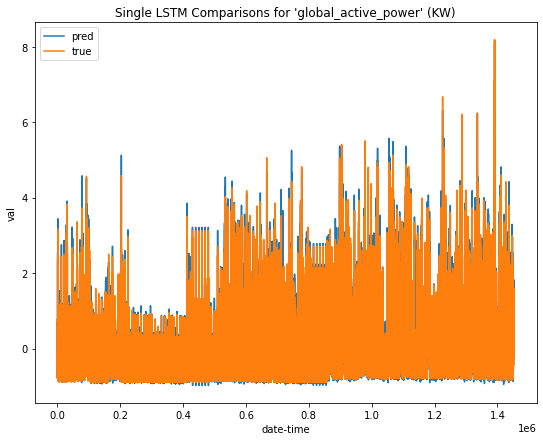

In [53]:
# Visualize future multi-step forecasting-
plt.figure(figsize = (9, 7))
plt.plot(preditcions.flatten(), label = 'pred')
plt.plot(y_test.flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("Single LSTM Comparisons for 'global_active_power' (KW)")
plt.legend(loc = 'best')
plt.show()

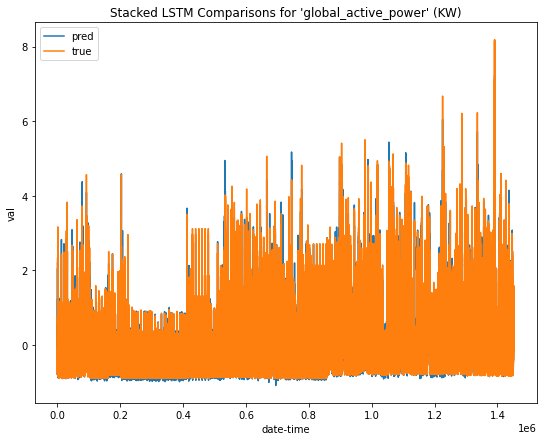

In [75]:
# Visualize future multi-step forecasting-
plt.figure(figsize = (9, 7))
plt.plot(predictions_stacked.flatten(), label = 'pred')
plt.plot(y_test.flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("Stacked LSTM Comparisons for 'global_active_power' (KW)")
plt.legend(loc = 'best')
plt.show()

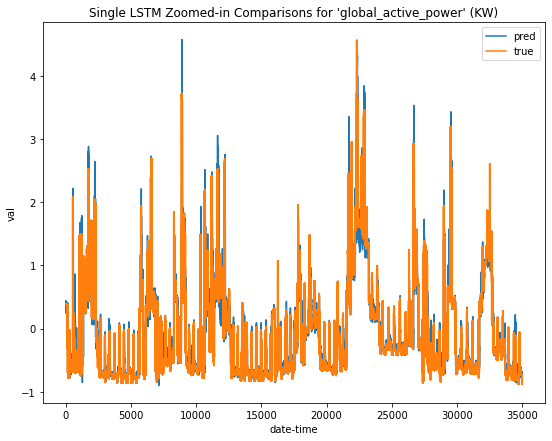

In [54]:
# Visualize future multi-step forecasting-
plt.figure(figsize = (9, 7))
plt.plot(preditcions[10000:15000].flatten(), label = 'pred')
plt.plot(y_test[10000:15000].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("Single LSTM Zoomed-in Comparisons for 'global_active_power' (KW)")
plt.legend(loc = 'best')
plt.show()

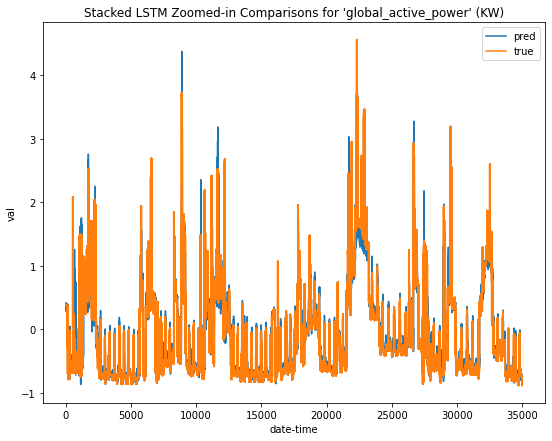

In [77]:
# Visualize future multi-step forecasting-
plt.figure(figsize = (9, 7))
plt.plot(predictions_stacked[10000:15000].flatten(), label = 'pred')
plt.plot(y_test[10000:15000].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("Stacked LSTM Zoomed-in Comparisons for 'global_active_power' (KW)")
plt.legend(loc = 'best')
plt.show()

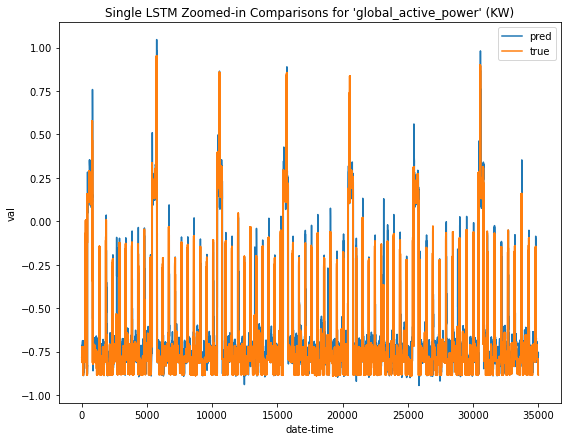

In [55]:
# Visualize future multi-step forecasting-
plt.figure(figsize = (9, 7))
plt.plot(preditcions[50000:55000].flatten(), label = 'pred')
plt.plot(y_test[50000:55000].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("Single LSTM Zoomed-in Comparisons for 'global_active_power' (KW)")
plt.legend(loc = 'best')
plt.show()

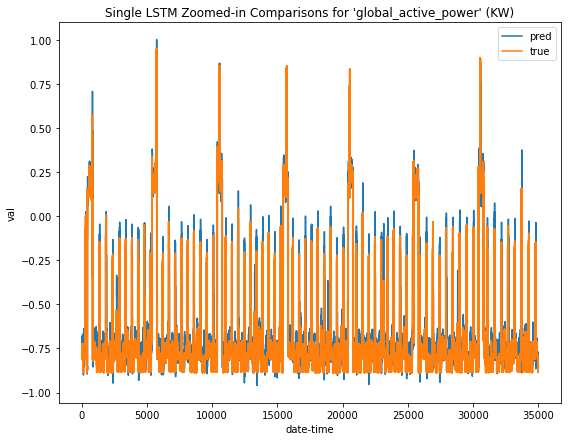

In [78]:
# Visualize future multi-step forecasting-
plt.figure(figsize = (9, 7))
plt.plot(predictions_stacked[50000:55000].flatten(), label = 'pred')
plt.plot(y_test[50000:55000].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("Single LSTM Zoomed-in Comparisons for 'global_active_power' (KW)")
plt.legend(loc = 'best')
plt.show()

In [80]:
# Compare metrics on test dataset-
mae = mean_absolute_error(y_true = y_test.flatten(), y_pred = preditcions.flatten())
mse = mean_squared_error(y_true = y_test.flatten(), y_pred = preditcions.flatten())

In [81]:
mae_stacked = mean_absolute_error(y_true = y_test.flatten(), y_pred = predictions_stacked.flatten())
mse_stacked = mean_squared_error(y_true = y_test.flatten(), y_pred = predictions_stacked.flatten())

In [82]:
print("LSTM metrics on test set are:")
print(f"Single MAE = {mae:.5f} & Stacked MAE = {mae_stacked:.5f}")
print(f"Single MSE = {mse:.5f} & Stacked MSE = {mse_stacked:.5f}")

LSTM metrics on test set are:
Single MAE = 0.15216 & Stacked MAE = 0.14760
Single MSE = 0.09855 & Stacked MSE = 0.09538


In [47]:
# Save trained weights-
model_lstm.save_weights("Single_LSTM_Trained_global_active_power.h5", overwrite = True)

In [79]:
model_lstm_stacked.save_weights("Stacked_LSTM_Trained_global_active_power.h5", overwrite = True)

In [83]:
del model_lstm, model_lstm_stacked

### Encoder-Decoder LSTM Model With Multivariate Out# Define hyper-parameters for Seq2Seq modeling-

In this architecture, the model will not output a vector sequence directly. Instead, the architecture consists of two sub architectures/models:
1. the encoder to read and encode the input sequence, (and)
1. the decoder that will read the encoded input sequence and make a one/multi-step prediction for each element in the output sequence.

The difference is subtle, as in practice both approaches do in fact predict a sequence output.

The important difference is that an LSTM model is used in the decoder, allowing it to know both what was predicted for the prior day in the sequence and the accumulated internal state while outputting/predicting the sequence.

In [30]:
# Define hyper-parameters for Seq2Seq modeling:

# number of past data points/samples to train on (look-back window size)-
n_past = 30

# number of future time-steps to predict for (multistep)-
n_future = 10

# number of features/attributes to use while training (multivariate)-
n_features = 8

In [31]:
# Specify hyper-parameters-
num_epochs = 100
batch_size = 256

In [32]:
# Split into training and testing sets for supervised task-
X_train, y_train = split_series_multivariate(train_data, n_past, n_future)
X_test, y_test = split_series_multivariate(test_data, n_past, n_future)

In [33]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1867694, 30, 8), y_train.shape: (1867694, 10, 8)
X_test.shape: (207487, 30, 8), y_test.shape: (207487, 10, 8)


### Define Seq2Seq LSTM Encoder-Decoder architecture using _Model Sub-classing_ of TF2

In [61]:
class LSTM_Encoder(Model):
    '''
    LSTM Encoder definition for Multivariate, Multistep
    Multivariate time-series prediction.
    '''
    def __init__(
        self, num_units,
        n_future, n_features,
        n_past
    ):
        super(LSTM_Encoder, self).__init__()
        self.num_units = num_units
        self.n_future = n_future
        self.n_features = n_features
        self.n_past = n_past
        
        self.lstm1 = LSTM(
            units = self.num_units, activation = tf.keras.activations.tanh,
            return_sequences = False, return_state = False,
            recurrent_activation = 'sigmoid', use_bias = True,
            input_shape = (self.n_past, self.n_features)
        )
        self.repeat_vector = RepeatVector(n = self.n_future)
    
    
    def call(self, x):
        x = self.lstm1(x)
        x = self.repeat_vector(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.lstm1(x)
        print(f"First LSTM output shape: {x.shape}")
        x = self.repeat_vector(x)
        print(f"Repeat Vector output shape: {x.shape}")
        del x
        return None
    
    

In [43]:
class LSTM_Decoder(Model):
    '''
    LSTM Decoder definition for Multivariate, Multistep
    Multivariate time-series prediction.
    '''
    def __init__(
        self, num_units,
        n_features
    ):
        super(LSTM_Decoder, self).__init__()
        self.num_units = num_units
        self.n_features = n_features
        
        self.lstm1 = LSTM(
            units = self.num_units[0], activation  = tf.keras.activations.tanh,
            return_sequences = True, return_state = False
        )
        self.time_distributed1 = TimeDistributed(
            Dense(units = self.num_units[1], activation = tf.keras.activations.relu)
        )
        self.time_distributed2 = TimeDistributed(
            Dense(units = self.n_features, activation = None)
        )

    
    def call(self, x):
        x = self.lstm1(x)
        x = self.time_distributed1(x)
        x = self.time_distributed2(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.lstm1(x)
        print(f"First LSTM output shape: {x.shape}")
        x = self.time_distributed1(x)
        print(f"First TimeDistributed output shape: {x.shape}")
        x = self.time_distributed2(x)
        print(f"Second TimeDistributed output shape: {x.shape}")
        del x
        return None
    

In [63]:
# Initialize LSTM Encoder-
lstm_enc = LSTM_Encoder(
    num_units = 128, n_future = n_future,
    n_features = n_features, n_past = n_past
)

In [64]:
# Initialize LSTM Decoder-
lstm_dec = LSTM_Decoder(
    num_units = [128, 64], n_features = n_features
)

In [65]:
# Sanity check-
enc_out = lstm_enc(X_train[:batch_size, :])

In [66]:
enc_out.shape

TensorShape([256, 10, 128])

In [67]:
# Sanity check-
dec_out = lstm_dec(enc_out)

In [69]:
dec_out.shape, y_train[:batch_size, :].shape

(TensorShape([256, 10, 8]), (256, 10, 8))

In [70]:
lstm_enc.shape_computation(X_train[:batch_size, :])

Input shape: (256, 30, 8)
First LSTM output shape: (256, 128)
Repeat Vector output shape: (256, 10, 128)


In [71]:
lstm_dec.shape_computation(enc_out)

Input shape: (256, 10, 128)
First LSTM output shape: (256, 10, 128)
First TimeDistributed output shape: (256, 10, 64)
Second TimeDistributed output shape: (256, 10, 8)


In [72]:
del dec_out, enc_out, lstm_enc, lstm_dec

In [76]:
class LSTM_Encoder_Decoder(Model):
    '''
    LSTM Encoder-Decoder architecture definition for Multivariate,
    Multistep Multivariate time-series prediction.
    '''
    def __init__(
        self, enc_units, dec_units,
        n_past, n_features,
        n_future
    ):
        super(LSTM_Encoder_Decoder, self).__init__()
        self.enc_units = enc_units
        self.dec_units = dec_units
        self.n_past = n_past
        self.n_features = n_features
        self.n_future = n_future
        
        self.lstm_encoder = lstm_enc = LSTM_Encoder(
            num_units = self.enc_units, n_future = self.n_future,
            n_features = self.n_features, n_past = self.n_past
        )
        self.lstm_decoder = LSTM_Decoder(
            num_units = self.dec_units, n_features = self.n_features
        )
    
    
    def call(self, x):
        x = self.lstm_encoder(x)
        x = self.lstm_decoder(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x - self.lstm_encoder(x)
        print(f"LSTM encoder output shape: {x.shape}")
        x = self.lstm_decoder(x)
        print(f"LSTM decoder output shape: {x.shape}")
        del x
        return None
    

In [79]:
# Initialize LSTM encoder-
lstm_enc = LSTM_Encoder(
    num_units = 128, n_future = n_future,
    n_features = n_features, n_past = n_past
)

In [81]:
# Initialize LSTM decoder-
lstm_dec = LSTM_Decoder(
    num_units = [128, 64], n_features = n_features
)

In [77]:
# Initialize LSTM Encoder-Decoder-
lstm_enc_dec = LSTM_Encoder_Decoder(
    enc_units = 128, dec_units = [128, 64],
    n_past = n_past, n_features = n_features,
    n_future = n_future
)

In [82]:
# Sanity check-
out = lstm_enc(X_train[:5, :])

In [83]:
out.shape

TensorShape([5, 10, 128])

In [84]:
out_dec = lstm_dec(out)

In [86]:
out_dec.shape, y_train[:5, :].shape

(TensorShape([5, 10, 8]), (5, 10, 8))

In [87]:
lstm_enc.shape_computation(X_train[:5, :])

Input shape: (5, 30, 8)
First LSTM output shape: (5, 128)
Repeat Vector output shape: (5, 10, 128)


In [88]:
lstm_dec.shape_computation(out)

Input shape: (5, 10, 128)
First LSTM output shape: (5, 10, 128)
First TimeDistributed output shape: (5, 10, 64)
Second TimeDistributed output shape: (5, 10, 8)


In [89]:
out = lstm_enc_dec(X_train[:batch_size, :])

In [90]:
out.shape, y_train[:batch_size, :].shape, X_train[:batch_size, :].shape

(TensorShape([256, 10, 8]), (256, 10, 8), (256, 30, 8))

In [91]:
del out, out_dec, lstm_enc, lstm_dec

In [92]:
# Get model summary-
lstm_enc_dec.summary()

Model: "lstm__encoder__decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm__encoder_5 (LSTM_Encod  multiple                 70144     
 er)                                                             
                                                                 
 lstm__decoder_2 (LSTM_Decod  multiple                 140360    
 er)                                                             
                                                                 
Total params: 210,504
Trainable params: 210,504
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Define LR scheduler-
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [97]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 5, verbose = 1,
    mode = 'min', baseline = None,
    restore_best_weights = True
)

In [95]:
# Compile model-
lstm_enc_dec.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.Huber()
)

In [98]:
# Train model-
history_e1d1 = lstm_enc_dec.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/100
7296/7296 [==============================] - 35s 5ms/step - loss: 0.0751 - val_loss: 0.0726
Epoch 2/100
7296/7296 [==============================] - 34s 5ms/step - loss: 0.0742 - val_loss: 0.0723
Epoch 3/100
7296/7296 [==============================] - 34s 5ms/step - loss: 0.0733 - val_loss: 0.0726
Epoch 4/100
7296/7296 [==============================] - 33s 5ms/step - loss: 0.0726 - val_loss: 0.0722
Epoch 5/100
7296/7296 [==============================] - 35s 5ms/step - loss: 0.0718 - val_loss: 0.0729
Epoch 6/100
7296/7296 [==============================] - 34s 5ms/step - loss: 0.0713 - val_loss: 0.0732
Epoch 6: early stopping


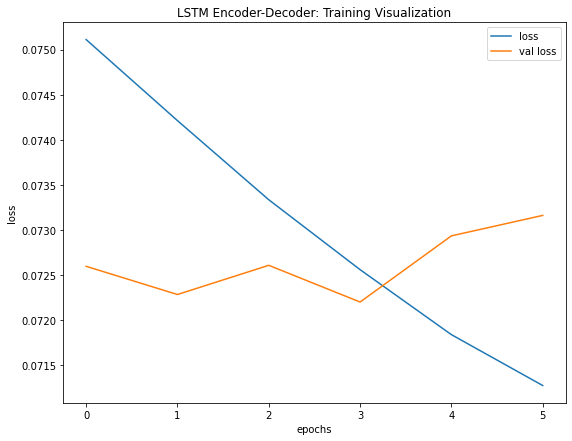

In [99]:
# Visualize training losses-
plt.figure(figsize = (9, 7))
plt.plot(history_e1d1.history['loss'], label = 'loss')
plt.plot(history_e1d1.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM Encoder-Decoder: Training Visualization")
plt.legend(loc = 'best')
plt.show()

In [100]:
# Create TF test dataset to iterate over-
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size = batch_size)

In [101]:
# Python3 list to contain batch wise predictions-
predictions = []

In [102]:
for x in test_dataset:
    y_pred = lstm_enc_dec.predict(x)
    predictions.append(y_pred)

In [103]:
# Sanity check-
len(predictions)

811

In [104]:
# Convert from Python3 list to np arrays-
predictions = np.vstack(predictions)

In [105]:
# Sanity check-
predictions.shape, y_test.shape

((207487, 10, 8), (207487, 10, 8))

In [106]:
# Compute different metrics-
mse_ed = np.mean(np.square(predictions.flatten() - y_test.flatten()))
rmse_ed = np.sqrt(mse_ed)
mae_ed = np.mean(np.abs(predictions.flatten() - y_test.flatten()))

In [107]:
print("Trained model validation metrics:")
print(f"E1-D1; MSE: {mse_ed:.4f}, RMSE: {rmse_ed:.4f} & MAE: {mae_ed:.4f}")

Trained model validation metrics:
E1-D1; MSE: 0.1994, RMSE: 0.4466 & MAE: 0.1981


### Comparison Visualizations: Real vs. Predictions ∀ features

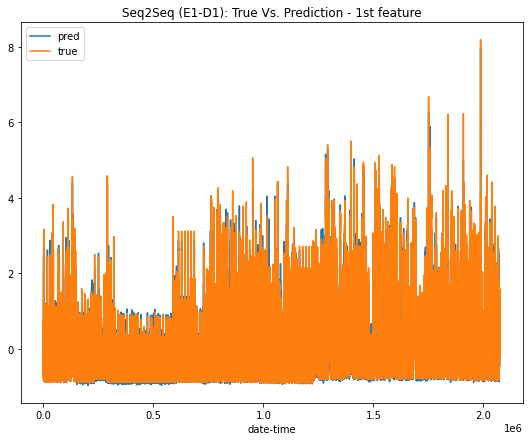

In [108]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 0].flatten(), label = 'pred')
plt.plot(y_test[:, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

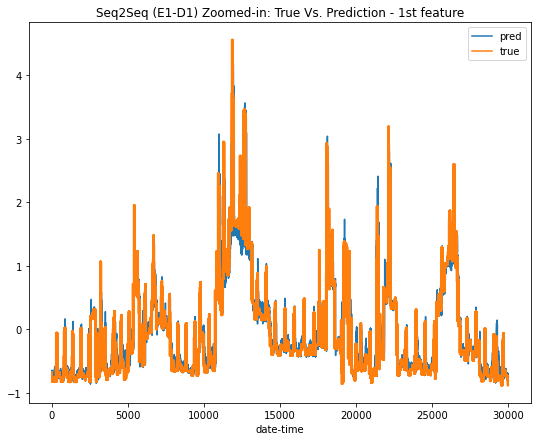

In [109]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 0].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

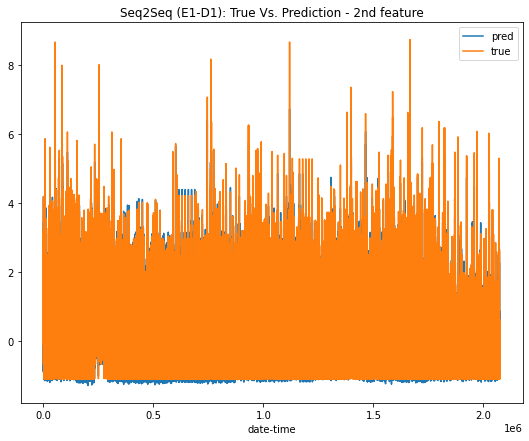

In [110]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 1].flatten(), label = 'pred')
plt.plot(y_test[:, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

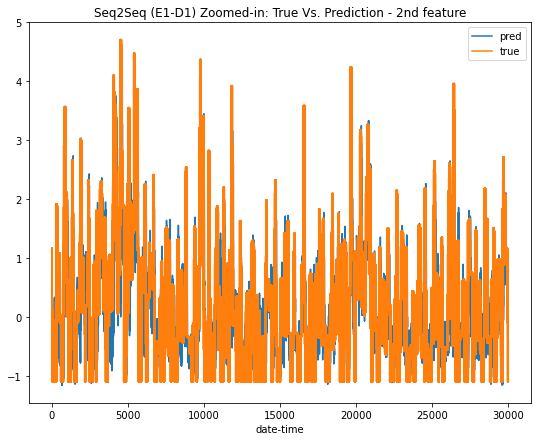

In [111]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 1].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

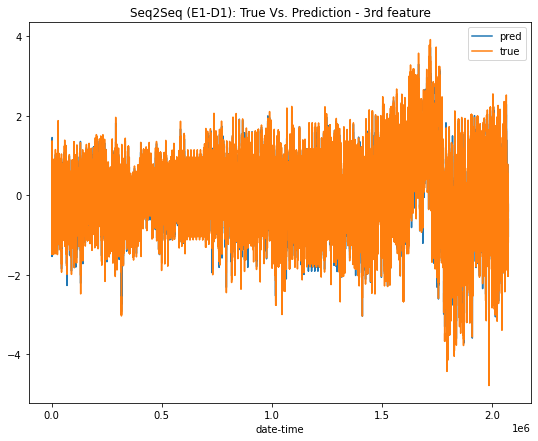

In [112]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 2].flatten(), label = 'pred')
plt.plot(y_test[:, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

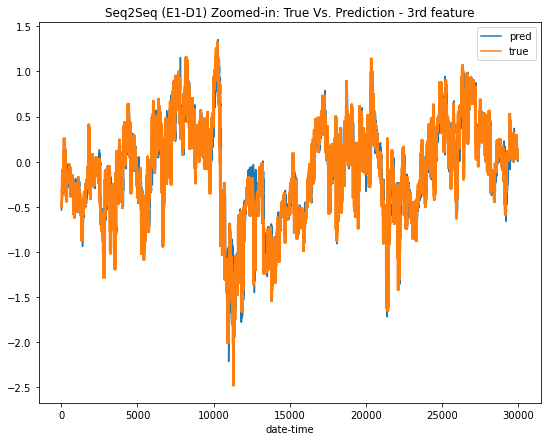

In [113]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 2].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

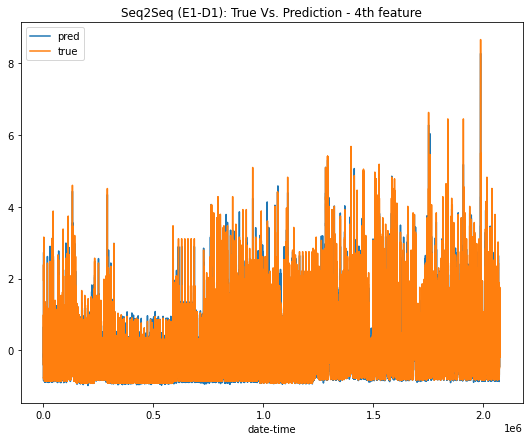

In [114]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 3].flatten(), label = 'pred')
plt.plot(y_test[:, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

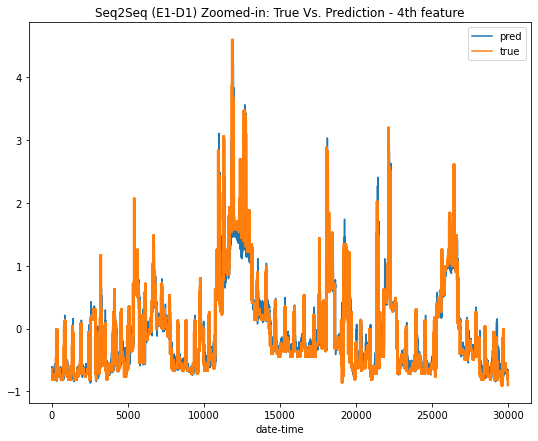

In [118]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 3].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

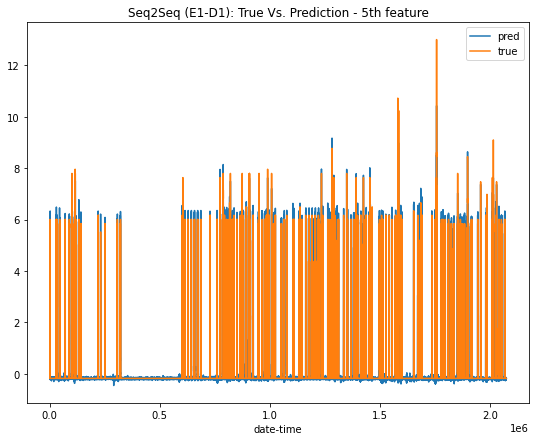

In [116]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 4].flatten(), label = 'pred')
plt.plot(y_test[:, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()

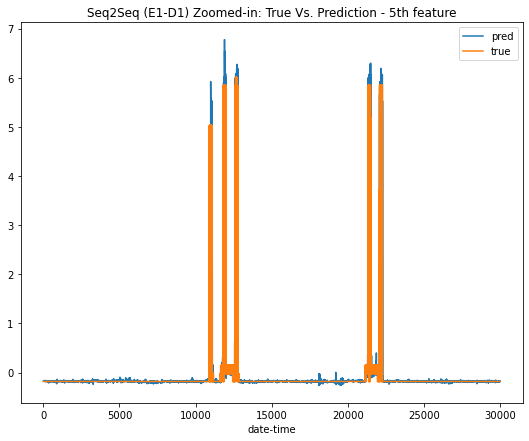

In [117]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 4].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()

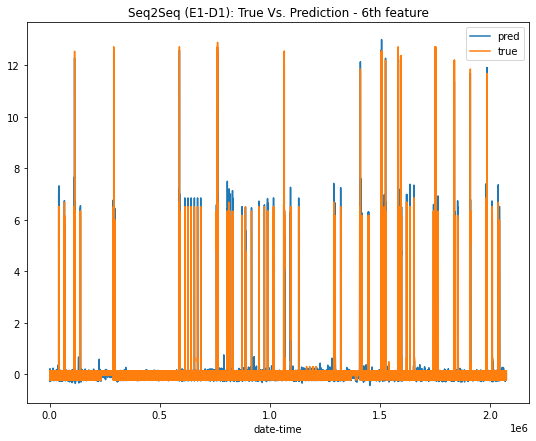

In [119]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 5].flatten(), label = 'pred')
plt.plot(y_test[:, :, 5].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 6th feature")
plt.legend(loc = 'best')
plt.show()

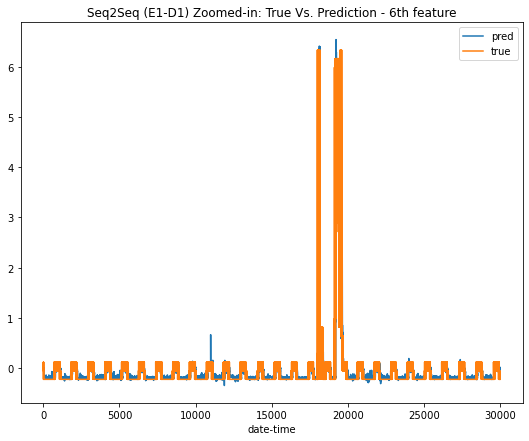

In [120]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 5].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 5].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 6th feature")
plt.legend(loc = 'best')
plt.show()

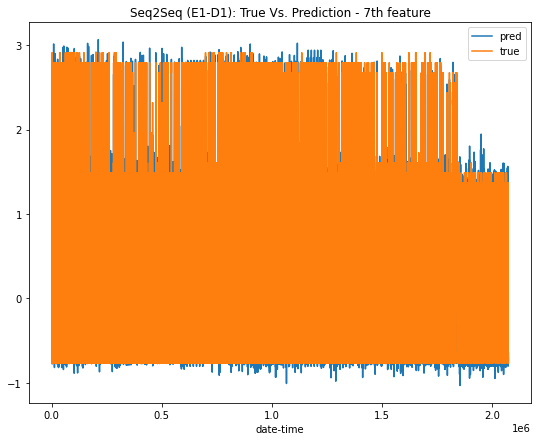

In [121]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 6].flatten(), label = 'pred')
plt.plot(y_test[:, :, 6].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 7th feature")
plt.legend(loc = 'best')
plt.show()

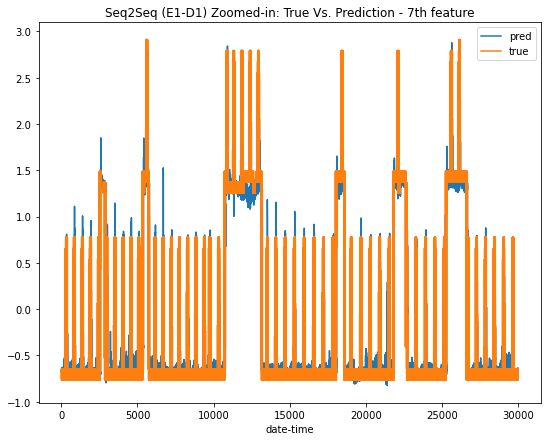

In [122]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 6].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 6].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 7th feature")
plt.legend(loc = 'best')
plt.show()

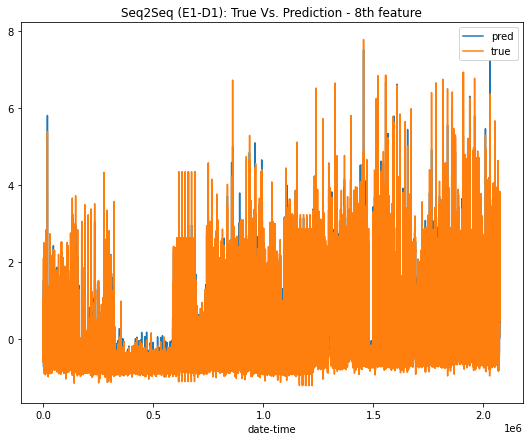

In [123]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[:, :, 7].flatten(), label = 'pred')
plt.plot(y_test[:, :, 7].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1): True Vs. Prediction - 8th feature")
plt.legend(loc = 'best')
plt.show()

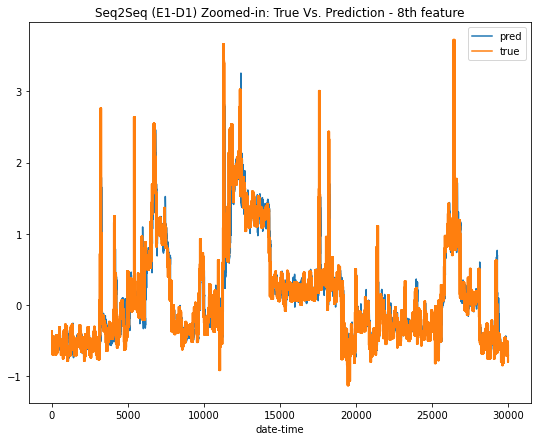

In [124]:
plt.figure(figsize = (9, 7))
plt.plot(predictions[12000:15000, :, 7].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 7].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (E1-D1) Zoomed-in: True Vs. Prediction - 8th feature")
plt.legend(loc = 'best')
plt.show()

### CNN-LSTM Encoder-Decoder Model With Univariate Input

A convolutional neural network, or CNN, can be used as the encoder in an encoder-decoder architecture.

The CNN does not directly support sequence input; instead, a 1D CNN is capable of reading across sequence input and automatically learning the salient features. These can then be interpreted by an LSTM decoder as per normal. We refer to hybrid models that use a CNN and LSTM as [CNN-LSTM models](https://machinelearningmastery.com/cnn-long-short-term-memory-networks/), and in this case we are using them together in an encoder-decoder architecture.

The CNN expects the input data to have the same 3D structure as the LSTM model, although multiple features are read as different channels that ultimately have the same effect.

We will simplify the example and focus on the CNN-LSTM with univariate input, but it can just as easily be updated to use multivariate input, which is left as an exercise.

As before, we will use input sequences comprised of 14 days of daily total power consumption.

We will define a simple but effective CNN architecture for the encoder that is comprised of two convolutional layers followed by a max pooling layer, the results of which are then flattened.

The first convolutional layer reads across the input sequence and projects the results onto feature maps. The second performs the same operation on the feature maps created by the first layer, attempting to amplify any salient features. We will use 64 feature maps per convolutional layer and read the input sequences with a kernel size of three time steps.

The max pooling layer simplifies the feature maps by keeping 1/4 of the values with the largest (max) signal. The distilled feature maps after the pooling layer are then flattened into one long vector that can then be used as input to the decoding process.

In [127]:
class CNN_Encoder(Model):
    def __init__(
        self, num_filters,
        pool_size, kernel_size,
        n_past, n_features
    ):
        super(CNN_Encoder, self).__init__()
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.n_past = n_past
        self.n_features = n_features
        
        self.conv1 = Conv1D(
            filters = self.num_filters, kernel_size = self.kernel_size,
            activation = tf.keras.activations.relu,
            input_shape = (self.n_past, self.n_features)
        )
        self.conv2 = Conv1D(
            filters = self.num_filters, kernel_size = self.kernel_size,
            activation = tf.keras.activations.relu
        )
        self.pool = MaxPooling1D(pool_size = self.pool_size)
        self.flatten = Flatten()
    
    
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flatten(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"First conv output shape: {x.shape}")
        x = self.conv2(x)
        print(f"Second conv output shape: {x.shape}")
        x = self.pool(x)
        print(f"Max Pooling output shape: {x.shape}")
        x = self.flatten(x)
        print(f"Flattened output shape: {x.shape}")
        del x
        return None
    

In [137]:
class LSTM_CNN_Decoder(Model):
    def __init__(
        self, n_future,
        n_features, num_units,
        time_distributed_units
    ):
        super(LSTM_CNN_Decoder, self).__init__()
        self.n_future = n_future
        self.num_units = num_units
        self.n_features = n_features
        self.time_distributed_units = time_distributed_units
        
        self.repeat_vector = RepeatVector(n = self.n_future)
        self.lstm = LSTM(
            units = self.num_units, activation = tf.keras.activations.tanh,
            return_sequences = True
        )
        self.time_distributed = TimeDistributed(
            Dense(units = self.time_distributed_units, activation = tf.keras.activations.relu)
        )
        self.time_distributed2 = TimeDistributed(
            Dense(units = self.n_features, activation = tf.keras.activations.relu)
        )
    
    
    def call(self, x):
        x = self.repeat_vector(x)
        x = self.lstm(x)
        x = self.time_distributed(x)
        x = self.time_distributed2(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.repeat_vector(x)
        print(f"Repeat Vector output shape: {x.shape}")
        x = self.lstm(x)
        print(f"LSTM output shape: {x.shape}")
        x = self.time_distributed(x)
        print(f"TimeDistributed output shape: {x.shape}")
        x = self.time_distributed2(x)
        print(f"Second TimeDistributed output shape: {x.shape}")
        del x
        return None
        

In [142]:
class CNN_LSTM_Encoder_Decoder(Model):
    '''
    CNN-LSTM Encoder-Decoder architecture definition for Multivariate,
    Multistep Multivariate time-series prediction.
    '''
    def __init__(
        self, num_filters,
        kernel_size, dec_units,
        pool_size, time_distributed_units,
        n_past, n_features,
        n_future
    ):
        super(CNN_LSTM_Encoder_Decoder, self).__init__()
        
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dec_units = dec_units
        self.time_distributed_units = time_distributed_units
        self.n_past = n_past
        self.n_features = n_features
        self.n_future = n_future
        
        self.cnn_enc = CNN_Encoder(
            num_filters = self.num_filters, kernel_size = self.kernel_size,
            pool_size = self.pool_size, n_past = self.n_past,
            n_features = self.n_features
        )
        
        self.lstm_cnn_dec = LSTM_CNN_Decoder(
            n_future = self.n_future, n_features = self.n_features,
            num_units = self.dec_units, time_distributed_units = self.time_distributed_units
        )
    
    
    def call(self, x):
        x = self.cnn_enc(x)
        x = self.lstm_cnn_dec(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x - self.cnn_enc(x)
        print(f"CNN encoder output shape: {x.shape}")
        x = self.lstm_cnn_dec(x)
        print(f"LSTM decoder output shape: {x.shape}")
        del x
        return None
    



In [128]:
# Initialize CNN Encoder-
cnn_enc = CNN_Encoder(
    num_filters = 64, kernel_size = 3,
    pool_size = 2, n_past = n_past,
    n_features = n_features
)

In [138]:
# Initialize LSTM Decoder for CNN Encoder-
lstm_cnn_dec = LSTM_CNN_Decoder(
    n_future = n_future, n_features = n_features,
    num_units = 128, time_distributed_units = 100
)

In [129]:
# Sanity check-
out = cnn_enc(X_train[:batch_size, :])

In [130]:
out.shape

TensorShape([256, 832])

In [139]:
dec_out = lstm_cnn_dec(out)

In [140]:
dec_out.shape, y_train[:batch_size, :].shape

(TensorShape([256, 10, 8]), (256, 10, 8))

In [144]:
# Initialize CNN-LSTM Encoder-Decoder model-
model_cnn_lstm = CNN_LSTM_Encoder_Decoder(
    num_filters = 64, kernel_size = 3,
    dec_units = 128, pool_size = 2,
    time_distributed_units = 100,
    n_past = n_past, n_features = n_features,
    n_future = n_future
)

In [145]:
# Sanity check-
out = model_cnn_lstm(X_train[:batch_size, :])

In [146]:
out.shape, y_train[:batch_size, :].shape

(TensorShape([256, 10, 8]), (256, 10, 8))

In [147]:
del dec_out, out, cnn_enc, lstm_cnn_dec, lstm_dec, lstm_enc_dec

In [148]:
# Get model summary-
model_cnn_lstm.summary()

Model: "cnn_lstm__encoder__decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn__encoder_2 (CNN_Encoder  multiple                 13952     
 )                                                               
                                                                 
 lstm_cnn__decoder_3 (LSTM_C  multiple                 505740    
 NN_Decoder)                                                     
                                                                 
Total params: 519,692
Trainable params: 519,692
Non-trainable params: 0
_________________________________________________________________


In [149]:
print(f"number of features = {n_features}, number of past time-steps = {n_past}"
      f" and number of future time-step predictions = {n_future}")

number of features = 8, number of past time-steps = 30 and number of future time-step predictions = 10


In [150]:
# Compile model-
model_cnn_lstm.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.Huber()
)

In [151]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 5, verbose = 1,
    mode = 'min', baseline = None,
    restore_best_weights = True
)

In [152]:
# Train model-
history_conv_lstm = model_cnn_lstm.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/100
7296/7296 [==============================] - 29s 4ms/step - loss: 0.2336 - val_loss: 0.1955
Epoch 2/100
7296/7296 [==============================] - 28s 4ms/step - loss: 0.2278 - val_loss: 0.1930
Epoch 3/100
7296/7296 [==============================] - 28s 4ms/step - loss: 0.2180 - val_loss: 0.1661
Epoch 4/100
7296/7296 [==============================] - 28s 4ms/step - loss: 0.1909 - val_loss: 0.1659
Epoch 5/100
7296/7296 [==============================] - 28s 4ms/step - loss: 0.1898 - val_loss: 0.1660
Epoch 6/100
7296/7296 [==============================] - 28s 4ms/step - loss: 0.1890 - val_loss: 0.1657
Epoch 7/100
7296/7296 [==============================] - 27s 4ms/step - loss: 0.1882 - val_loss: 0.1659
Epoch 8/100
7296/7296 [==============================] - 28s 4ms/step - loss: 0.1876 - val_loss: 0.1663
Epoch 8: early stopping


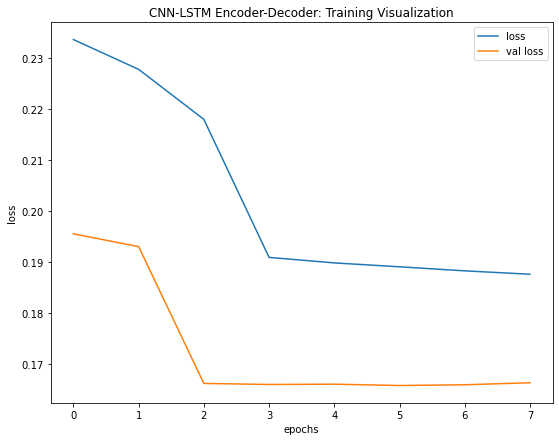

In [153]:
plt.figure(figsize = (9, 7))
plt.plot(history_conv_lstm.history['loss'], label = 'loss')
plt.plot(history_conv_lstm.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("CNN-LSTM Encoder-Decoder: Training Visualization")
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Create TF test dataset to iterate over-
# test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size = batch_size)

In [154]:
# Python3 list to contain batch wise predictions-
predictions_cnn_lstm = []

In [156]:
for x in test_dataset:
    y_pred = model_cnn_lstm.predict(x)
    predictions_cnn_lstm.append(y_pred)

In [157]:
# Sanity check-
len(predictions_cnn_lstm)

811

In [158]:
# Convert from Python3 list to np arrays-
predictions_cnn_lstm = np.vstack(predictions_cnn_lstm)

In [159]:
# Sanity check-
predictions_cnn_lstm.shape, y_test.shape

((207487, 10, 8), (207487, 10, 8))

In [163]:
# Compute different metrics-
mse_cnn_lstm = np.mean(np.square(predictions_cnn_lstm.flatten() - y_test.flatten()))
rmse_cnn_lstm = np.sqrt(mse_cnn_lstm)
mae_cnn_lstm = np.mean(np.abs(predictions_cnn_lstm.flatten() - y_test.flatten()))

In [164]:
print("Trained model validation metrics:")
print(f"CNN-LSTM; MSE: {mse_cnn_lstm:.4f}, RMSE: {rmse_cnn_lstm:.4f} & MAE: {mae_cnn_lstm:.4f}")
print(f"LSTM (E1-D1); MSE: {mse_ed:.4f}, RMSE: {rmse_ed:.4f} & MAE: {mae_ed:.4f}")

Trained model validation metrics:
CNN-LSTM; MSE: 0.4190, RMSE: 0.6473 & MAE: 0.4473
LSTM (E1-D1); MSE: 0.1994, RMSE: 0.4466 & MAE: 0.1981


#### Observation:
It seems that _LSTM Encoder-Decoder_ architecture performs better as compared to _CNN-Encoder & LSTM-Decoder_ architecture, for this particular instance. Results might most probably vary for subsequent executions.

### Comparison Visualizations: Real vs. Predictions ∀ features

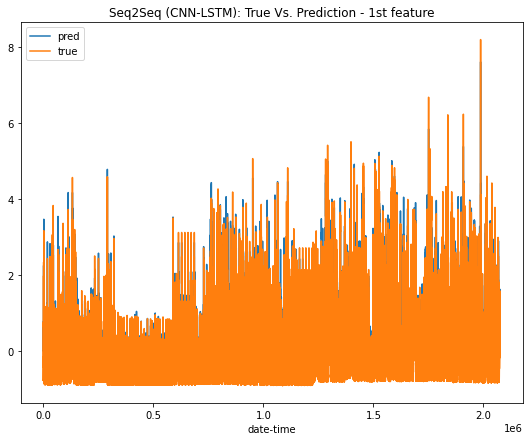

In [166]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 0].flatten(), label = 'pred')
plt.plot(y_test[:, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

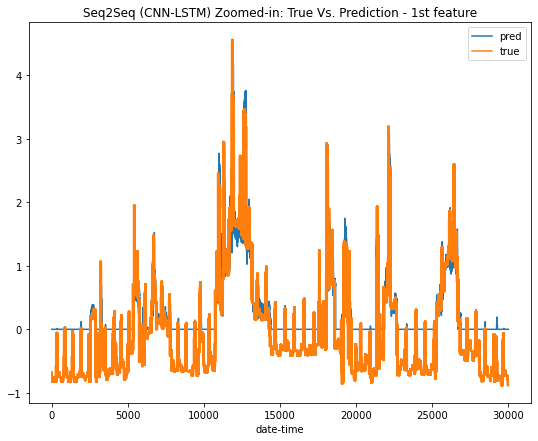

In [167]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 0].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 1st feature")
plt.legend(loc = 'best')
plt.show()

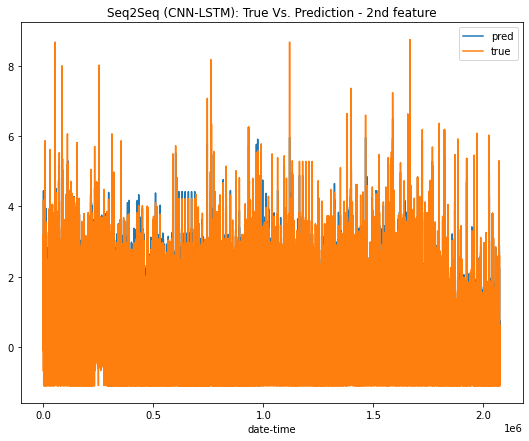

In [168]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 1].flatten(), label = 'pred')
plt.plot(y_test[:, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

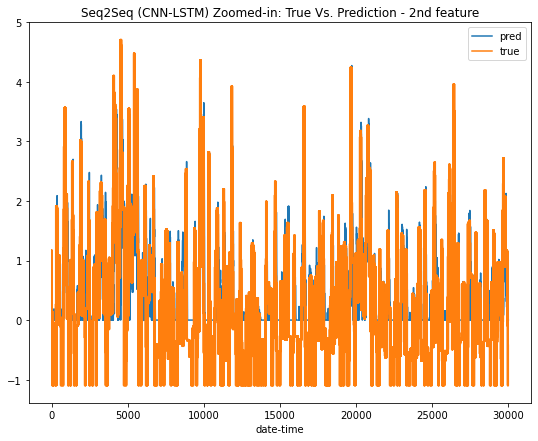

In [169]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 1].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 2nd feature")
plt.legend(loc = 'best')
plt.show()

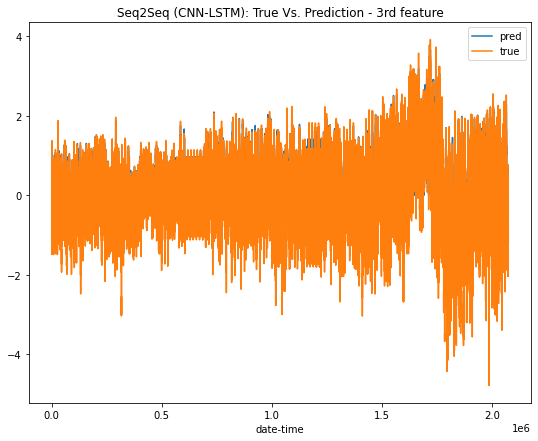

In [170]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 2].flatten(), label = 'pred')
plt.plot(y_test[:, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

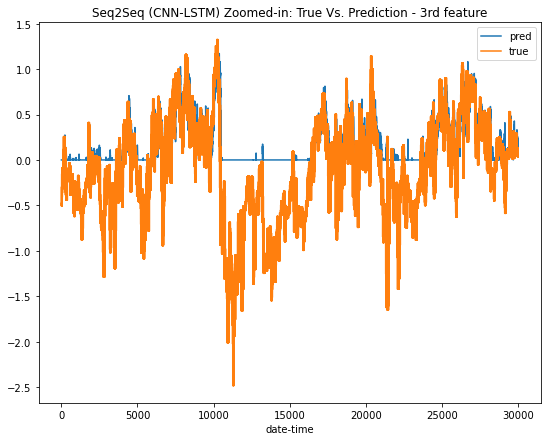

In [171]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 2].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 3rd feature")
plt.legend(loc = 'best')
plt.show()

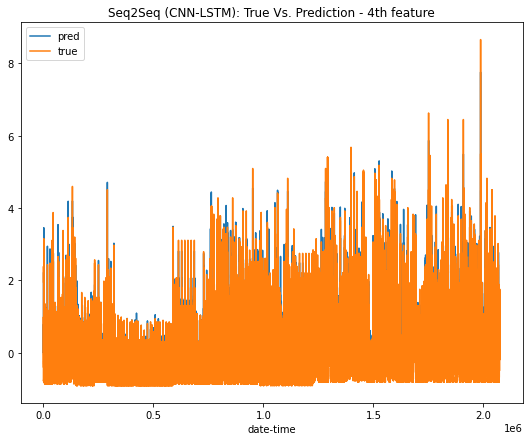

In [172]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 3].flatten(), label = 'pred')
plt.plot(y_test[:, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

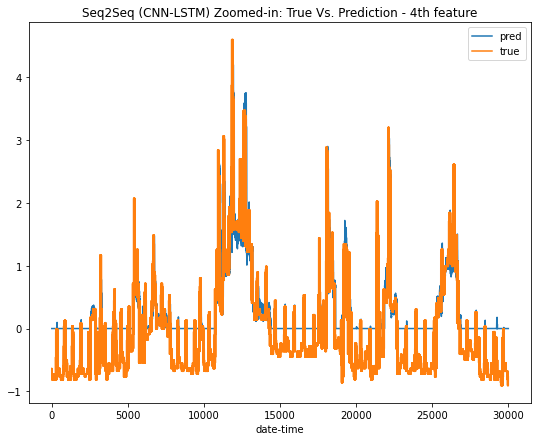

In [173]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 3].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 4th feature")
plt.legend(loc = 'best')
plt.show()

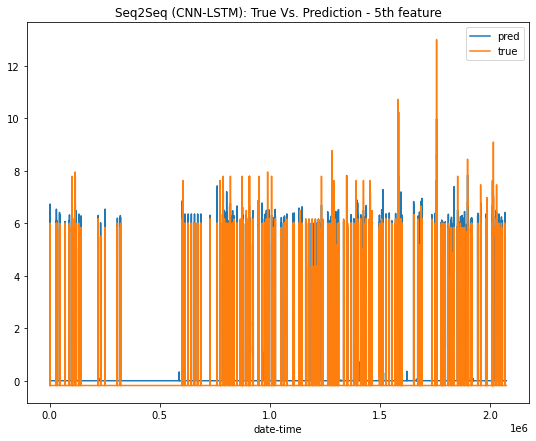

In [174]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 4].flatten(), label = 'pred')
plt.plot(y_test[:, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()

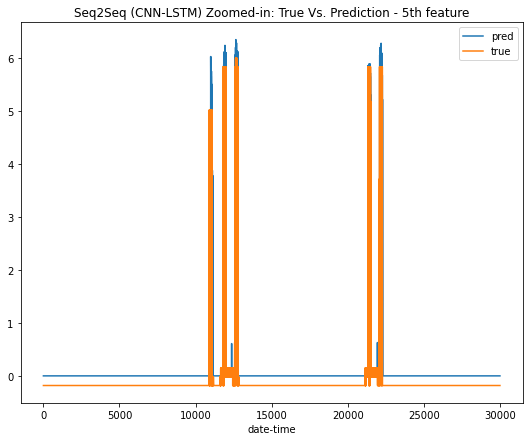

In [175]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 4].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 5th feature")
plt.legend(loc = 'best')
plt.show()

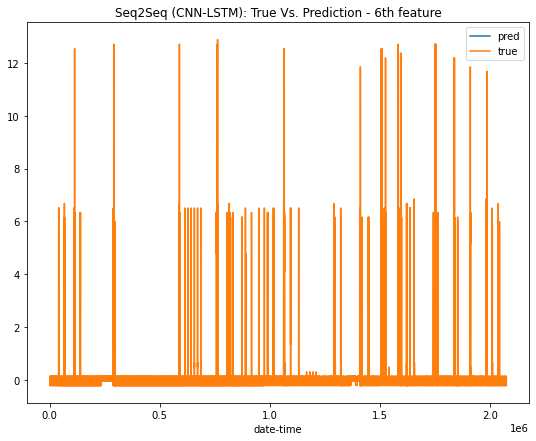

In [176]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 5].flatten(), label = 'pred')
plt.plot(y_test[:, :, 5].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 6th feature")
plt.legend(loc = 'best')
plt.show()

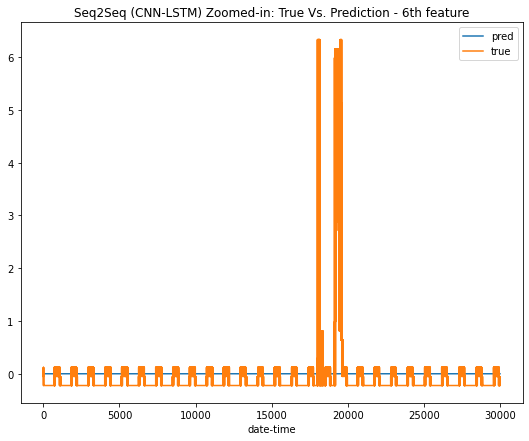

In [177]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 5].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 5].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 6th feature")
plt.legend(loc = 'best')
plt.show()

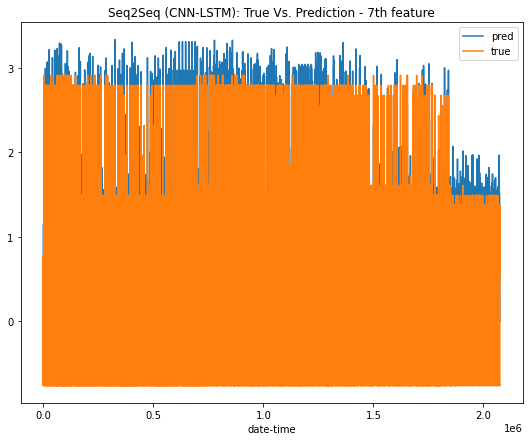

In [178]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 6].flatten(), label = 'pred')
plt.plot(y_test[:, :, 6].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 7th feature")
plt.legend(loc = 'best')
plt.show()

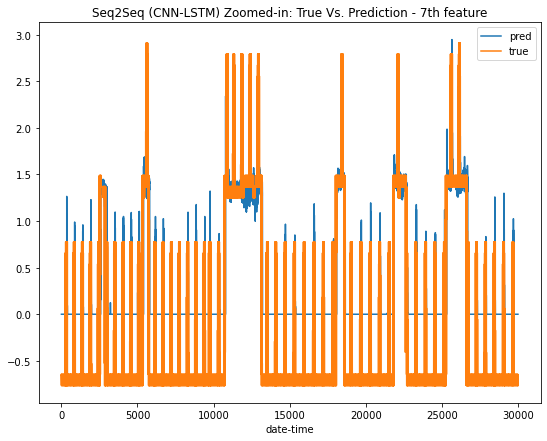

In [179]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 6].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 6].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 7th feature")
plt.legend(loc = 'best')
plt.show()

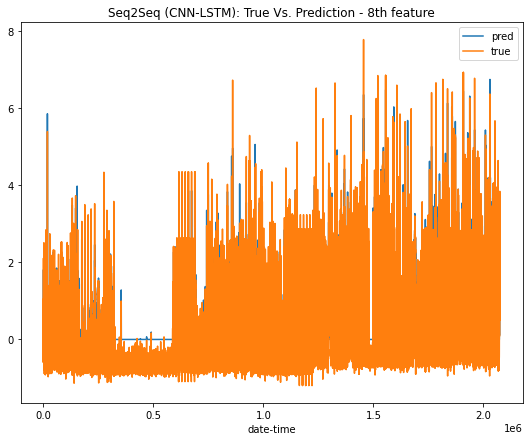

In [180]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[:, :, 7].flatten(), label = 'pred')
plt.plot(y_test[:, :, 7].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM): True Vs. Prediction - 8th feature")
plt.legend(loc = 'best')
plt.show()

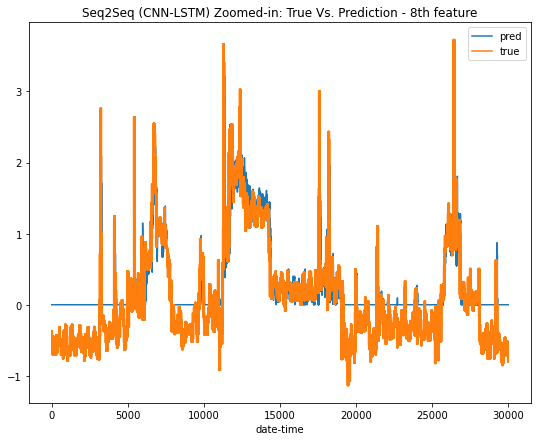

In [181]:
plt.figure(figsize = (9, 7))
plt.plot(predictions_cnn_lstm[12000:15000, :, 7].flatten(), label = 'pred')
plt.plot(y_test[12000:15000, :, 7].flatten(), label = 'true')
plt.xlabel("date-time")
plt.title("Seq2Seq (CNN-LSTM) Zoomed-in: True Vs. Prediction - 8th feature")
plt.legend(loc = 'best')
plt.show()

#### Visual Observations

The visual plots also confirm that for this particular example, _LSTM Encoder-Decoder_ seems to perform better when compared to _CNN-LSTM Encoder-Decoder_ architecture.

### ConvLSTM Encoder-Decoder Model With Univariate Input

A further extension of the CNN-LSTM approach is to perform the convolutions of the CNN (e.g. how the CNN reads the input sequence data) as part of the LSTM for each time step.

This combination is called a Convolutional LSTM, or ConvLSTM for short, and like the CNN-LSTM is also used for spatio-temporal data.

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.

For more information for how the equations for the ConvLSTM are calculated within the LSTM unit, refer to the research paper [Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting](https://arxiv.org/abs/1506.04214v1).

The Keras library provides the ```ConvLSTM2D``` class that supports the ```ConvLSTM``` model for 2D data. It can be configured for 1D multivariate time series forecasting.

__The ConvLSTM2D class, by default, expects input data to have the shape: ```[samples, timesteps, rows, cols, channels]```.__

Where each time step of data is defined as an image of $(rows \times columns)$ data points.

We are working with a one-dimensional sequence of total power consumption, which we can interpret as one row with 14 columns, if we assume that we are using two weeks of data as input.

For the ConvLSTM, this would be a single read: that is, the LSTM would read one time step of 14 days and perform a convolution across those time steps.

This is not ideal.

In [124]:
print(f"number of features = {n_features}, number of past time-steps = {n_past}"
      f" and number of future time-step predictions = {n_future}")

number of features = 8, number of past time-steps = 30 and number of future time-step predictions = 7
